In [ ]:
import math
import os
import random
import zipfile
from importlib import reload
from io import BytesIO


import matplotlib.pyplot as plt
import mglyph as mg
import numpy as np
import torch
import torchvision
import torchvision.transforms.functional as TF
from IPython.display import clear_output, display
from matplotlib import pyplot as plt
from PIL import Image
from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.io import ImageReadMode

import mglyph_ml
import mglyph_ml.lib as lib
from mglyph_ml.data.glyph_dataset import GlyphDataset, GlyphSample
from mglyph_ml.dataset.glyph_importer import GlyphImporter
from mglyph_ml.manifest_parsing import Manifest
from mglyph_ml.nn.training import train_one_epoch

# Reload all mglyph_ml modules to pick up code changes

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
# here, we simply set up a glyph provider that out GlyphDataset will use to load glyphs from the export
train_glyphs = ["train-square.mglyph", "train-triangle.mglyph", "train-circle.mglyph"]
importers_train = [
    GlyphImporter(f"data/glyphs-experiment-1/{glyph}") for glyph in train_glyphs
]
dataset_train: GlyphDataset = GlyphDataset(*importers_train)

test_glyphs = ["test-square.mglyph", "test-triangle.mglyph", "test-circle.mglyph"]
importers = [
    GlyphImporter(f"data/glyphs-experiment-1/{glyph}") for glyph in test_glyphs
]
dataset_test: GlyphDataset = GlyphDataset(
    *importers,
    augmentation_seed=69
)  # Changed from importers_train to importers_test

In [4]:
# we create a temporary dataset with normalization turned off so that we can see what exactly is fed into the NN
temp_dataset: GlyphDataset = GlyphDataset(*importers, normalize=False, augmentation_seed=69)

In [5]:
# we get a couple of random indices from the dataset so that we can test if the augmentation
# is always the same
random_sample_indices = random.sample(range(len(temp_dataset)), 9)

In [6]:
# Visualize random test samples using the utility function
from mglyph_ml.nn.training import visualize_samples

# visualize_samples(
#     importers=importers,
#     num_samples=12,
#     figsize=(6, 6),
#     augmentation_seed=69
# )

In [7]:
# quick sanity check before training
# we check that the input data is of the expected shape and properly normalized
print("Sample image shape:", dataset_train[0][0])
print("Sample label:", dataset_train[0][1])

Sample image shape: tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
Sample label: tensor(0.2032)


In [8]:
# next, we create the model
from mglyph_ml.nn.glyph_regressor_gen2 import GlyphRegressor
model = GlyphRegressor()
# we move the model to the GPU for much faster training (if GPU is available)
if device == 'cuda':
    model = model.to(device)

In [9]:
from mglyph_ml.nn.training import evaluate_glyph_regressor

In [10]:
from mglyph_ml.nn.training import train_model

indices_debug = list(range(0, len(dataset_train), 16))
dataset_debug = Subset(dataset_train, indices_debug)

# simply change the dataset to any other, and train :)
# data_loader_train = DataLoader(dataset_debug, batch_size=16, shuffle=True)
data_loader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
data_loader_test = DataLoader(dataset_test, batch_size=64)

criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0003, momentum=0.00001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model with visualization
losses, errors, test_losses, test_errors = train_model(
    model=model,
    data_loader_train=data_loader_train,
    data_loader_test=data_loader_test,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    early_stopping_threshold=0.3
)

print(losses)
print(errors)
print(test_losses)
print(test_errors)

[0.08209700546668548, 0.001269021748540629, 0.0007384230679905924, 0.0005841235374406862, 0.0004916783065326806, 0.0003896147919524657, 0.0002854275501847855, 0.0002066133131034133, 0.00013264462636710194, 0.00012170922165846845]
[20.84974943611183, 2.832624914222642, 2.1018530977399723, 1.8582361872847144, 1.6821564714375297, 1.5393494897963185, 1.313444788224603, 1.0776051969610547, 0.8565035709915193, 0.85090837000232]
[0.005236825975589454, 0.0009341609664261341, 0.00045235605211928486, 0.001100839165155776, 0.0013549139373935759, 0.0007515057135606184, 0.0009171526180580258, 0.0010691422852687539, 0.0010725265135988593, 0.00046782330318819734]
[7.126985043287277, 2.496639844030142, 1.79645374417305, 2.7654121536761522, 3.160274811089039, 2.243432179093361, 2.5623995810747147, 2.859576605260372, 2.8247602097690105, 1.8063149601221085]


In [11]:
# Let's check the actual dataset sizes and understand why convergence is fast
print("=" * 60)
print("DATASET SIZE ANALYSIS")
print("=" * 60)
print(f"Full training dataset size: {len(dataset_train)}")
print(f"Debug subset size (every 16th): {len(list(range(0, len(dataset_train), 16)))}")
print(f"Test dataset size: {len(dataset_test)}")
print(f"\nBatch size: 64")
print(f"Batches per epoch (debug): {len(list(range(0, len(dataset_train), 16))) / 64:.1f}")
print(f"Batches per epoch (full): {len(dataset_train) / 64:.1f}")
print("\nNote: Using only every 16th sample means the model sees very little data!")
print("Consider training on the full dataset or increasing the subset size.")
print("=" * 60)

DATASET SIZE ANALYSIS
Full training dataset size: 2400
Debug subset size (every 16th): 150
Test dataset size: 600

Batch size: 64
Batches per epoch (debug): 2.3
Batches per epoch (full): 37.5

Note: Using only every 16th sample means the model sees very little data!
Consider training on the full dataset or increasing the subset size.


In [12]:
# Saving and loading the model!
# torch.save(model, )

Training Set Statistics:
  Mean Error: -0.13 x units
  Std Dev:    0.99 x units
  Min Error:  -3.68 x units
  Max Error:  3.91 x units

Test Set Statistics:
  Mean Error: 1.54 x units
  Std Dev:    1.67 x units
  Min Error:  -2.94 x units
  Max Error:  5.73 x units


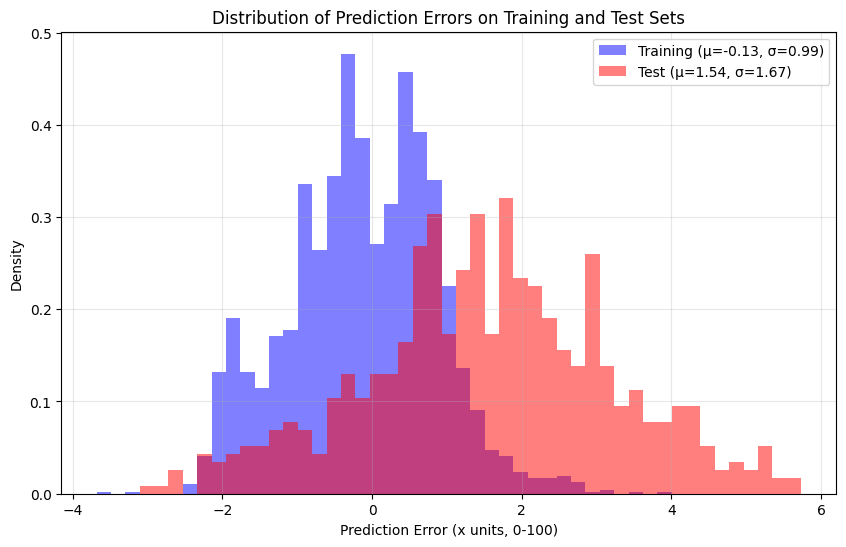

In [13]:
# Evaluate all examples and collect errors
model.eval()
model = model.to(device)
train_errors = []
test_errors = []

with torch.no_grad():
    # Evaluate training set
    for i in range(len(dataset_train)):
        input, label = dataset_train[i]
        img_batch = input.unsqueeze(0).to(device)
        pred = model(img_batch).item()
        error = (pred - label) * 100  # Convert to x units (0-100)
        train_errors.append(error)
    
    # Evaluate test set
    dataset_test.reset_transform()
    for i in range(len(dataset_test)):
        input, label = dataset_test[i]
        img_batch = input.unsqueeze(0).to(device)
        pred = model(img_batch).item()
        error = (pred - label) * 100  # Convert to x units (0-100)
        test_errors.append(error)

train_mean = np.mean(train_errors)
train_std = np.std(train_errors)
test_mean = np.mean(test_errors)
test_std = np.std(test_errors)

plt.figure(figsize=(10, 6))
bins = np.linspace(min(min(train_errors), min(test_errors)), 
                   max(max(train_errors), max(test_errors)), 50)

plt.hist(train_errors, bins=bins, alpha=0.5, label=f'Training (μ={train_mean:.2f}, σ={train_std:.2f})', 
         density=True, color='blue')
plt.hist(test_errors, bins=bins, alpha=0.5, label=f'Test (μ={test_mean:.2f}, σ={test_std:.2f})', 
         density=True, color='red')

plt.xlabel('Prediction Error (x units, 0-100)')
plt.ylabel('Density')
plt.title('Distribution of Prediction Errors on Training and Test Sets')
plt.legend()
plt.grid(True, alpha=0.3)

print(f"Training Set Statistics:")
print(f"  Mean Error: {train_mean:.2f} x units")
print(f"  Std Dev:    {train_std:.2f} x units")
print(f"  Min Error:  {min(train_errors):.2f} x units")
print(f"  Max Error:  {max(train_errors):.2f} x units")
print(f"\nTest Set Statistics:")
print(f"  Mean Error: {test_mean:.2f} x units")
print(f"  Std Dev:    {test_std:.2f} x units")
print(f"  Min Error:  {min(test_errors):.2f} x units")
print(f"  Max Error:  {max(test_errors):.2f} x units")

plt.show()

In [14]:
# Visualize predictions on test samples using the utility function
from mglyph_ml.nn.training import visualize_test_predictions

visualize_test_predictions(
    model=model,
    importers=importers,
    device=device,
    num_samples=9,
    figsize=(6, 6),
    augmentation_seed=69
)

ImportError: cannot import name 'visualize_test_predictions' from 'mglyph_ml.nn.training' (/zfs-pool/home/xgaens00/mglyph-ml/src/mglyph_ml/nn/training.py)

In [ ]:
from torch import nn
# here, we can analyze the model a little bit, see what it's doing internally
def visualize_kernels(model: nn.Module, layer_idx: int = 0, ncols: int = 8, figsize=(10,10), cmap="viridis"):
    """
    Visualize convolution kernels from the model's feature extractor.
    - If kernel has 3 input channels, shows as RGB.
    - Otherwise shows averaged (grayscale) kernel per output channel.
    - layer_idx: 0 for first conv, 1 for second conv, 2 for third conv
    """
    # get the conv layer from sequential
    conv_layers = [module for module in model.features if isinstance(module, nn.Conv2d)]
    if layer_idx >= len(conv_layers):
        raise ValueError(f"Layer index {layer_idx} is out of range. Model has {len(conv_layers)} conv layers.")
    
    layer = conv_layers[layer_idx]
    weight = layer.weight.detach().cpu()  # shape: (out_ch, in_ch, kH, kW)
    out_ch, in_ch, _, _ = weight.shape

    nrows = math.ceil(out_ch / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.array(axes).reshape(-1)

    for i in range(nrows * ncols):
        ax = axes[i]
        ax.axis("off")
        if i >= out_ch:
            continue
        kern = weight[i]  # (in_ch, kH, kW)
        if in_ch == 3:
            # to H,W,C for display; normalize per-filter
            img = kern.permute(1, 2, 0).numpy()
            # normalize to 0..1
            mi, ma = img.min(), img.max()
            if ma - mi > 0:
                img = (img - mi) / (ma - mi)
            ax.imshow(img)
            ax.set_title(f"f{i} (RGB)")
        else:
            # average across input channels -> single plane
            img = kern.mean(dim=0).numpy()
            mi, ma = img.min(), img.max()
            if ma - mi > 0:
                img = (img - mi) / (ma - mi)
            ax.imshow(img, cmap=cmap)
            ax.set_title(f"f{i} (avg)")
    plt.tight_layout()
    return fig

# After training
# Visualize the three convolutional layers
fig1 = visualize_kernels(model, layer_idx=0, ncols=4, figsize=(8,8))  # First conv (16 kernels)
plt.show()
fig2 = visualize_kernels(model, layer_idx=1, ncols=8, figsize=(8,4))  # Second conv (32 kernels)
plt.show()
fig3 = visualize_kernels(model, layer_idx=2, ncols=8, figsize=(8,8))  # Third conv (64 kernels)
plt.show()

In [ ]:
import os
from PIL import Image
import numpy as np

def export_kernels(model: torch.nn.Module, layer_name: str, out_dir: str, cmap: str = "viridis"):
    """
    Export all kernels from a specified convolutional layer to images in `out_dir`.
    - If kernels have 3 input channels, saves as RGB images.
    - Otherwise, saves as grayscale images (averaged over input channels).
    """
    os.makedirs(out_dir, exist_ok=True)
    layer = getattr(model, layer_name, None)
    if layer is None:
        raise ValueError(f"Model has no attribute '{layer_name}'")
    weight = layer.weight.detach().cpu()  # (out_ch, in_ch, kH, kW)
    out_ch, in_ch, kH, kW = weight.shape
    for i in range(out_ch):
        kern = weight[i]  # (in_ch, kH, kW)
        if in_ch == 3:
            # RGB kernel: (3, kH, kW) -> (kH, kW, 3)
            img = kern.permute(1, 2, 0).numpy()
            mi, ma = img.min(), img.max()
            if ma - mi > 0:
                img = (img - mi) / (ma - mi)
            img = (img * 255).astype(np.uint8)
            im = Image.fromarray(img, mode="RGB")
        else:
            # Grayscale: average over input channels
            img = kern.mean(dim=0).numpy()
            mi, ma = img.min(), img.max()
            if ma - mi > 0:
                img = (img - mi) / (ma - mi)
            img = (img * 255).astype(np.uint8)
            im = Image.fromarray(img, mode="L")
        out_path = os.path.join(out_dir, f"{layer_name}_kernel_{i}.png")
        im.save(out_path)
    print(f"Exported {out_ch} kernels from '{layer_name}' to {out_dir}")

export_kernels(model=model, layer_name="conv3", out_dir="data/kernels")